In [82]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from random import shuffle,sample
import math
import csv
import glob
import scipy.io
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import Imputer, LabelEncoder, LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
import sklearn.preprocessing as preprocessing
%matplotlib inline
import scipy
from pylab import *
from random import shuffle,sample
import re
from scipy.special import expit
import time
from sklearn import cross_validation
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D

# Prediction Performance Summary
## for cross entropy 0.94140 (learning rate 0.01, num=60000, 200 hidden)
## for mse 0.92500 (learning rate 0.01, num=60000, 200 hidden)
## for cross entropy 0.94320 (learning rate 0.01, num=60000, 600 hidden)
## for cross entropy 0.94340 (regular=0.0001, learning rate 0.01, num 60000, 200 hidden (best))
## for cross entropy 0.94280 (regular=0.0001, learning rate 0.01, num 60000, 600 hidden)

In [2]:
###Read in Data and preprocessing
train = scipy.io.loadmat('dataset/train.mat')
test = scipy.io.loadmat('dataset/test.mat')

In [3]:
X_train = train['train_images']
Y_train = train['train_labels'].ravel()
X_test = test['test_images']
print X_test.shape
print X_train.shape

(10000, 28, 28)
(28, 28, 60000)


# Preprocessing Data, add bias term to X

In [4]:
###convert each image from 28*28 matrix to a 784 vector
X_train_update=[]
for i in range(X_train.shape[2]):
    X_train_update.append(np.hstack(X_train[...,i]))
X_train=np.asarray(X_train_update)
X_train.shape

(60000, 784)

In [5]:
X_test_update=[]
for i in range(X_test.shape[0]):
    X_test_update.append(np.hstack(X_test[i,...]))
X_test_kaggle=np.asarray(X_test_update)
print X_test_kaggle.shape

(10000, 784)


In [6]:
X_pre_train = preprocessing.StandardScaler().fit_transform(X_train)
X_pre_test = preprocessing.StandardScaler().fit_transform(X_test_kaggle)

/Users/chenglulu1127/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got uint8
  "got %s" % (estimator, X.dtype))


In [7]:
X_train = np.hstack((np.ones((X_pre_train.shape[0],1)),X_pre_train))
X_test = np.hstack((np.ones((X_pre_test.shape[0],1)),X_pre_test))

# Define stochastic gradient descent for neural network

In [8]:
def predict(test,V,W):
    h = np.hstack((np.ones((test.shape[0],1)),np.tanh(np.dot(test,V.T))))
    s = expit(np.dot(W,h.T))      
    pred = np.argmax(s,axis=0)
    return pred

In [78]:
###stochastic gradient descent function
def SGD_Neuralnet2(X,Y,seed_num,step=0.01,num_iter=10,costfunction=1,
                   num_hid=200,num_output=10,lamda=0):
    # X[t] is 1*785
    # W 10*201
    # V 200 * 785
    # h is 200*1
    # h1 is 201 * 1
    # s= s(Wh1) 10*1
    def MeanSE(X,Y,Y_vect,V,W):

        h = np.hstack((np.ones((X.shape[0],1)),np.tanh(np.dot(X,V.T))))
        s = expit(np.dot(W,h.T))      
        pred = np.argmax(s,axis=0)
        acc = np.sum(pred == Y)/Y.shape[0] ##Accuracy
        mse = np.sum(np.power(s.T - Y_vect,2))/2 ##MSE
        return acc, mse
    
    def CrossEntroy(X,Y,Y_vect,V,W):
        h = np.hstack((np.ones((X.shape[0],1)),np.tanh(np.dot(X,V.T))))
        s = expit(np.dot(W,h.T))      
        pred = np.argmax(s,axis=0)
        acc = np.sum(pred == Y)/Y.shape[0] ##Accuracy
        
        risk = -np.sum(np.multiply(np.log(s).T,Y_vect)+np.multiply(np.log(1-s).T,1-Y_vect)) 
        
        return acc, risk
    
    Emprisk_train=[]##emprical risk
    Acc_train=[]##accuracy
    num_input = X.shape[1]
    
    ##random shuffle data
    rd.seed(seed_num)
    index = rd.sample(range(X.shape[0]),X.shape[0])
    X = X[index]
    Y = Y[index]
    
    ###convert vector Y 50000*1 into binarized Y_vect 50000*10
    le = preprocessing.LabelEncoder()
    aa=le.fit_transform(Y)
    LB = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
    newY = LB.fit_transform(aa)
    
     
    ##initialize weights with fan-in
    np.random.seed(seed_num)
    V = (1/sqrt(num_input))*np.random.randn(num_hid,num_input)
    W = (1/sqrt(num_hid+1))*np.random.randn(num_output,num_hid+1)
    i = 0

    while i <= num_iter:
        #print W.shape,V.shape
        t = rd.sample(range(X.shape[0]),1)
        h = np.squeeze(np.asarray(np.tanh(np.dot(V,X[t].T))))
        #print h.shape
        h1 = np.squeeze(np.asarray(np.hstack((1,h)))) ##h1 is 201 * 1 add bias term
        #print h1.shape
        s = np.squeeze(np.asarray(expit(np.dot(W,h1)))) ##s is 10 * 1
        #print s.shape
        ##create a vector of y coding response
        y_vect = np.squeeze(np.asarray(newY[[t]]))
        #print y_vect.shape
        if costfunction == 1:
        ##mean squared error update
            dW=np.dot(np.mat((s-y_vect)*(1-s)*s).T,np.mat(h1))+ 2*lamda*W## 10*201
            #print dW.shape
            #print s.shape,h1.shape,W.shape
            temp = np.mat(np.dot(W[:,1:].T,(s-y_vect)*(1-s)*s)).T
            dV=np.dot(np.mat(np.squeeze(np.asarray(temp))*(1-np.power(h,2))).T,X[t]) 
            ##V is 200 * 785
            #print dV.shape
            #print dV.shape
            #print s.shape,h1.shape
        ##cross entropy update
        if costfunction != 1: 
            dW=np.dot(np.mat((s-y_vect)).T,np.mat(h1)) + 2*lamda*W## 10*201
            temp = np.mat(np.dot(W[:,1:].T,(s-y_vect))).T
            dV=np.dot(np.mat(np.squeeze(np.asarray(temp))*(1-np.power(h,2))).T,X[t])
        
        V = V - step * dV
        W = W - step * dW 
        #print W.shape, V.shape
        if i % 1000 ==0:
            if costfunction == 1:
                acc_train,risk_train = MeanSE(X,Y,newY,V,W)
                Emprisk_train.append(risk_train)
                Acc_train.append(acc_train)
                
            if costfunction != 1:
                acc_train,risk_train = CrossEntroy(X,Y,newY,V,W)
                Emprisk_train.append(risk_train)
                Acc_train.append(acc_train)
                
        i+=1
        

        
    return Acc_train,Emprisk_train,V,W

# Total Training Time using MSE loss function

In [79]:
start =time.time()
acc_train,emprisk_train,V,W=SGD_Neuralnet2(X_train,Y_train,seed_num=132,step=0.01,
                                           num_iter=60000,costfunction=1,num_hid=200)
print time.time()-start

261.34798193


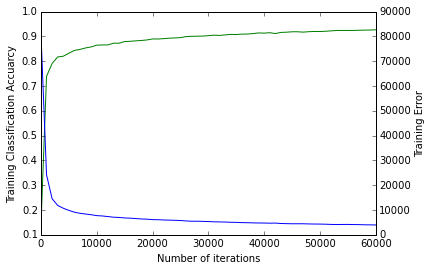

In [85]:
fig, ax1 = plt.subplots()

ax2 =ax1.twinx()
ax1.plot(np.arange(0,len(acc_train)*1000,1000),acc_train,'g-')
ax2.plot(np.arange(0,len(emprisk_train)*1000,1000),emprisk_train,'b-')

ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Training Classification Accuarcy')
ax2.set_ylabel('Training Error')


plt.savefig('train_mse.png')

# Total Training Time using cross-entropy loss function

In [86]:
start =time.time()
acc_train,emprisk_train,V,W=SGD_Neuralnet2(X_train,Y_train,seed_num=132,step=0.01,
                                           num_iter=60000,costfunction=2,num_hid=200)
print time.time()-start

219.529835939


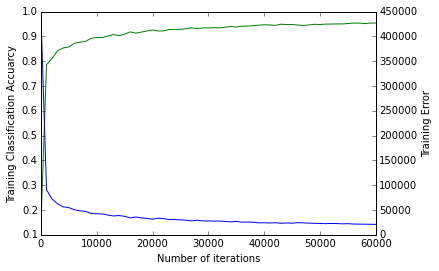

In [87]:
fig, ax1 = plt.subplots()

ax2 =ax1.twinx()
ax1.plot(np.arange(0,len(acc_train)*1000,1000),acc_train,'g-')
ax2.plot(np.arange(0,len(emprisk_train)*1000,1000),emprisk_train,'b-')

ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Training Classification Accuarcy')
ax2.set_ylabel('Training Error')


plt.savefig('train_ce.png')

# Prediction using 200 hidden units, learning rate 0.01, iterations 60000, cross-entropy error loss

In [598]:
acc_train2,emprisk_train2,V2,W2=SGD_Neuralnet2(X_train,Y_train,seed_num=132,step=0.01,
                                                                  num_iter=60000,
                                                                  costfunction=2,
                                                                  num_hid=200)

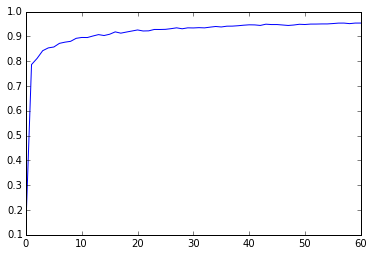

In [599]:
plt.plot(acc_train2)

In [689]:
pred = predict(X_test,V2,W2)

In [691]:
Y_submit = np.column_stack((range(1,10001),pred.T))
np.savetxt('digit.csv',Y_submit,delimiter=',',header='Id,Category')

# Prediction using 600 hidden units, learning rate 0.01, iterations 60000, cross-entropy error loss

In [12]:
acc_train3,emprisk_train3,V3,W3=SGD_Neuralnet2(X_train,Y_train,seed_num=132,step=0.01,
                                               num_iter=60000,costfunction=2,num_hid=600)

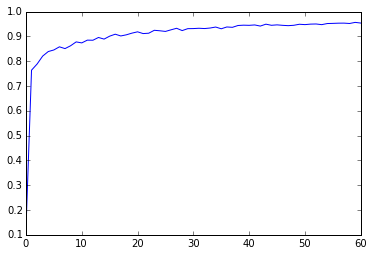

In [13]:
plt.plot(acc_train3)

In [20]:
pred3 = predict(X_test,V3,W3)

In [21]:
Y_submit = np.column_stack((range(1,10001),pred3.T))
np.savetxt('digit_600_cross.csv',Y_submit,delimiter=',',header='Id,Category')

# CV to regularize NERUAL NETWORK

In [34]:
###5-fold CV to select regularization parameter
fold_num = 5
kf = cross_validation.KFold(X_train.shape[0], n_folds=fold_num,shuffle=True)
lamda = [0.001,0.01,0.1,1]

avgacc=[]
ACC=[]
rd.seed(132)
X = X_train
Y = Y_train
for l in lamda:
    start = time.time()
    for train_index, test_index in kf:
        
        Xtrain = X[train_index]
        Ytrain = Y[train_index]
        Xtest =  X[test_index]
        Ytest =  Y[test_index]
                           
        train_acc, train_risk,V,W  = SGD_Neuralnet2(Xtrain,Ytrain,seed_num=132,
                                                       step=0.01,num_iter=50000,
                                                       costfunction=2,num_hid=200,
                                                        lamda=l)

        pred = predict(Xtest,V=V,W=W)
        test_acc = np.sum(pred == Ytest)/Ytest.shape[0]
        avgacc.append(test_acc)
    ACC.append(np.mean(avgacc))
    print "One CV completed using time: ", time.time() - start
    print "5-fold CV accuracy is ",np.mean(avgacc)

One CV completed using time:  2336.24528503
5-fold CV accuracy is  0.935333333333
One CV completed using time:  1620.76859403
5-fold CV accuracy is  0.927866666667
One CV completed using time:  2257.52843904
5-fold CV accuracy is  0.909916666667
One CV completed using time:  1619.831671
5-fold CV accuracy is  0.824829166667


In [37]:
##try another set of parameter
lamda = [0.00001,0.0001]

avgacc=[]
ACC=[]
rd.seed(132)
X = X_train
Y = Y_train
for l in lamda:
    start = time.time()
    for train_index, test_index in kf:
        
        Xtrain = X[train_index]
        Ytrain = Y[train_index]
        Xtest =  X[test_index]
        Ytest =  Y[test_index]
                           
        train_acc, train_risk,V,W  = SGD_Neuralnet2(Xtrain,Ytrain,seed_num=132,
                                                       step=0.01,num_iter=50000,
                                                       costfunction=2,num_hid=200,
                                                        lamda=l)

        pred = predict(Xtest,V=V,W=W)
        test_acc = np.sum(pred == Ytest)/Ytest.shape[0]
        avgacc.append(test_acc)
    ACC.append(np.mean(avgacc))
    print "One CV completed using time: ", time.time() - start
    print "5-fold CV accuracy is ",np.mean(avgacc)

One CV completed using time:  1679.83051586
5-fold CV accuracy is  0.93535
One CV completed using time:  2040.79534817
5-fold CV accuracy is  0.935016666667


# Best regularization is 0.0001 with 200 hidden units

In [35]:
acc_train4,emprisk_train4,V4,W4=SGD_Neuralnet2(X_train,Y_train,seed_num=132,step=0.01,
                                               num_iter=60000,costfunction=2,
                                               num_hid=200,lamda=0.0001)

[0.14198333333333332, 0.78651666666666664, 0.81141666666666667, 0.84238333333333337, 0.85355000000000003, 0.85731666666666662, 0.87190000000000001, 0.87665000000000004, 0.88001666666666667, 0.89233333333333331, 0.89536666666666664, 0.89524999999999999, 0.90144999999999997, 0.90680000000000005, 0.90325, 0.90848333333333331, 0.91741666666666666, 0.91286666666666672, 0.91816666666666669, 0.92188333333333339, 0.92618333333333336, 0.92291666666666672, 0.92131666666666667, 0.92756666666666665, 0.92878333333333329, 0.92905000000000004, 0.93348333333333333, 0.93518333333333337, 0.93025000000000002, 0.93336666666666668, 0.93264999999999998, 0.93348333333333333, 0.93313333333333337, 0.93700000000000006, 0.93825000000000003, 0.93661666666666665, 0.93896666666666662, 0.94048333333333334, 0.94348333333333334, 0.94618333333333338, 0.94601666666666662, 0.94540000000000002, 0.94335000000000002, 0.94796666666666662, 0.94728333333333337, 0.94911666666666672, 0.94503333333333328, 0.94801666666666662, 0.9

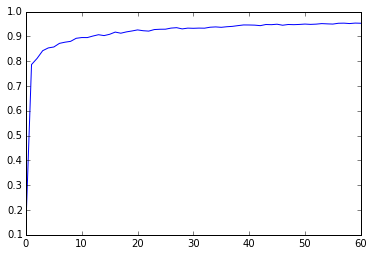

In [43]:
plt.plot(acc_train4)
print acc_train4

In [36]:
pred = predict(X_test,V4,W4)
Y_submit = np.column_stack((range(1,10001),pred.T))
np.savetxt('digit_reg.csv',Y_submit,delimiter=',',header='Id,Category')

# Best regularization is 0.0001 with 600 hidden units

In [38]:
start = time.time() 
acc_train5,emprisk_train5,V5,W5=SGD_Neuralnet2(X_train,Y_train,seed_num=132,step=0.01,
                                               num_iter=60000,costfunction=2,
                                               num_hid=600,lamda=0.0001)
print time.time() - start

1289.06189489


[0.11951666666666666, 0.76383333333333336, 0.7886333333333333, 0.82063333333333333, 0.83888333333333331, 0.84533333333333338, 0.85794999999999999, 0.85083333333333333, 0.86228333333333329, 0.87788333333333335, 0.87385000000000002, 0.88490000000000002, 0.88454999999999995, 0.89578333333333338, 0.88908333333333334, 0.90098333333333336, 0.90911666666666668, 0.90134999999999998, 0.90623333333333334, 0.91310000000000002, 0.91838333333333333, 0.91221666666666668, 0.91241666666666665, 0.92454999999999998, 0.92248333333333332, 0.92074999999999996, 0.92696666666666672, 0.93223333333333336, 0.92513333333333336, 0.93020000000000003, 0.93226666666666669, 0.93551666666666666, 0.93228333333333335, 0.93171666666666664, 0.93735000000000002, 0.9311666666666667, 0.93808333333333338, 0.9361666666666667, 0.94399999999999995, 0.94328333333333336, 0.94346666666666668, 0.94533333333333336, 0.93981666666666663, 0.94573333333333331, 0.94425000000000003, 0.94523333333333337, 0.94378333333333331, 0.9427166666666

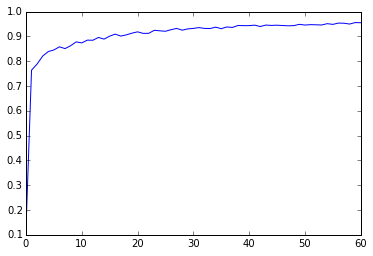

In [42]:
plt.plot(acc_train5)
print acc_train5

In [41]:
pred = predict(X_test,V5,W5)
Y_submit = np.column_stack((range(1,10001),pred.T))
np.savetxt('digit_reg_600.csv',Y_submit,delimiter=',',header='Id,Category')

# Bagging and Ensemble Nerual NET

In [69]:
def bagging_net(X,Y,test,bag_number,iteration=60000,step=0.01,lamda=0,costfunction=2,
                num_hid=200,seed=132):
    np.random.seed(seed)
    pred = []
    for i in range(bag_number):
        sample_index = np.random.choice(X.shape[0], X.shape[0], replace=True)
        train_X_bag = X[sample_index,:]
        train_Y_bag = Y[sample_index]
        a,aa,V_bag,W_bag=SGD_Neuralnet2(train_X_bag,train_Y_bag,
                                                       seed_num=seed,step=step,
                                                       num_iter=iteration,
                                                       costfunction=costfunction,
                                                       num_hid=num_hid,lamda=lamda)
        pred1 = predict(test,V_bag,W_bag)
        pred.append(pred1)
    result = asarray(pred)
    
    ##find majority vote
    axis = 0
    u, indices = np.unique(result, return_inverse=True)
    final = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(result.shape),
                                None, np.max(indices) + 1), axis=axis)]
    return final

In [74]:
t=time.time()
pred = bagging_net(X_train,Y_train,X_test,100,iteration=60000,step=0.01,lamda=0.0001,
                   costfunction=2,num_hid=200,seed=132)
print time.time()-t

29429.199111


In [76]:
Y_submit = np.column_stack((range(1,10001),pred.T))
np.savetxt('digit_bag.csv',Y_submit,delimiter=',',header='Id,Category')